In [3]:
from random import random, sample

In [4]:
import numpy as np

#### Generate test data

In [5]:
sample_rate = .25
sr_str = str(int(sample_rate*100))

In [ ]:
f = open('data/string_nonzero_experiments.csv')
num_links=0
for line in f:
    num_links+=1
print(num_links)

f = open('data/string_nonzero_experiments.csv')
proteins = set()
pairs = set()
uniq_pair_file = open('data/unique_string_nonzero_experiments.csv','w')
uniq_protein_file = open('data/unique_experiment_protein_ids.csv','w')

next(f)
for line in f:
    source, target, score = line.strip().split(',')
    
    if source not in proteins:
        uniq_protein_file.write(source + '\n')
    proteins.add(source)
    
    if target not in proteins:
        uniq_protein_file.write(target + '\n')
    proteins.add(target)
    
    if (source,target) not in pairs:
        uniq_pair_file.write(line)
    pairs.add((source,target))

print(len(proteins))
print(len(pairs))
uniq_pair_file.close()
uniq_protein_file.close()

f = open('data/string_nonzero_experiments.csv')

train_file = open('data/protein_pairs/train_split_' + sr_str + '.dat','w')
test_file = open('data/protein_pairs/test_split_' + sr_str + '.dat','w')
validation_file = open('data/protein_pairs/validation_split_' + sr_str + '.dat','w')
train_neg_file = open('data/protein_pairs/train_neg_split_' + sr_str + '.dat','w')
test_neg_file = open('data/protein_pairs/test_neg_split_' + sr_str + '.dat','w')
validation_neg_file = open('data/protein_pairs/validation_neg_split_' + sr_str + '.dat','w')

header = next(f)
train_file.write(header)
test_file.write(header)
validation_file.write(header)

for line in f:
    r = random()
    negative = tuple(sample(proteins, 2))
    while negative in pairs:
        negative = tuple(sample(proteins, 2))
    # Training set size determined by sampling rate
    if r >= sample_rate:
        train_file.write(line)
        train_neg_file.write(','.join(negative) + ',0\n')
    else:
        # Split non-training data into test/validation equally
        r = random()
        if r >= .5:
            test_file.write(line)
            test_neg_file.write(','.join(negative) + ',0\n')
        else:
            validation_file.write(line)
            validation_neg_file.write(','.join(negative) + ',0\n')


train_file.close()
test_file.close()
validation_file.close()
train_neg_file.close()
test_neg_file.close()
validation_neg_file.close()
f.close()

#### node2vec

In [6]:
import gensim
from node2vec import Node2Vec

C:\dev\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
import keras
import tensorflow as tf
import numpy as np

C:\dev\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
class Sequences:
    def __init__(self, filename):
        self.filename = filename
        self.f = open(self.filename)
    
    # this function is called each epoch of gensim training
    def __iter__(self):
        self.f = open(self.filename)
        return self
    
    def __next__(self):
        line = next(self.f)
        id,sequence = line.strip().split(',')
        sequence = sequence.split(' ')
        return gensim.models.doc2vec.TaggedDocument(tags=[id], words=sequence)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [10]:
from sklearn.metrics import classification_report, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score

In [23]:
from sklearn.utils.fixes import signature
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score

In [12]:
#Sample parameters
params = np.array([[
    5, #d2v_epochs
    35, #d2v_vector_size
    8, #d2v_window
    1, #d2v_min_count
    30, #n2v_dimensions
    5, #n2v_window
    7, #n2v_epochs
    5, #n2v_num_walks
    14, #n2v_walk_length
    5, #n2v_p
    5, #n2v_q
    0.824975636814739, #nn_dropout
]])
params.shape

(1, 12)

In [36]:
def pipeline(params):
    print(params.shape)
    d2v_epochs = int(params[0,0])
    d2v_vector_size = int(params[0,1])
    d2v_window = int(params[0,2])
    d2v_min_count = int(params[0,3])
    n2v_dimensions = int(params[0,4])
    n2v_window = int(params[0,5])
    n2v_epochs = int(params[0,6])
    n2v_num_walks = int(params[0,7])
    n2v_walk_length = int(params[0,8])
    n2v_p = int(params[0,9])
    n2v_q = int(params[0,10])
    nn_dropout = float(params[0,11])
    print('d2v_epochs = {}'.format(int(params[0,0])))
    print('d2v_vector_size = {}'.format(int(params[0,1])))
    print('d2v_window = {}'.format(int(params[0,2])))
    print('d2v_min_count = {}'.format(int(params[0,3])))
    print('n2v_dimensions = {}'.format(int(params[0,4])))
    print('n2v_window = {}'.format(int(params[0,5])))
    print('n2v_epochs = {}'.format(int(params[0,6])))
    print('n2v_num_walks = {}'.format(int(params[0,7])))
    print('n2v_walk_length = {}'.format(int(params[0,8])))
    print('n2v_p = {}'.format(int(params[0,9])))
    print('n2v_q = {}'.format(int(params[0,10])))
    print('nn_dropout = {}'.format(float(params[0,11])))

    training_edgelist_file = 'data/protein_pairs/train_split_' + sr_str + '.dat'

    print('Training Node2Vec'.center(80,'-'))
    n2v = Node2Vec()
    model = n2v.fit_transform(training_edgelist_file,
                              dimensions=n2v_dimensions, 
                              window=n2v_window,
                              epochs=n2v_epochs,
                              num_walks=n2v_num_walks, 
                              walk_length=n2v_walk_length, 
                              p=n2v_p, 
                              q=n2v_q,
                             )

    n2v.model.save('models/node2vec.model')

    # vectorfilename = 'data/vectors/node2vec_sample{}_p{}_q{}.dat'.format(sr_str, p, q)
    # vector_file = open(vectorfilename, 'w')
    # for i,n in enumerate(n2v.G.nodes):
    #     vector_file.write(n + ',' + ','.join([str(_) for _ in model.wv.vectors[i,:]]) + '\n')
    # vector_file.close()

    print('Node2Vec similarity to BRCA1'.center(80,'-'))
    for v in n2v.model.wv.most_similar('P38398|BRCA1_HUMAN'):
        print(v)

    #### doc2vec

    filename = 'data/split_human_uniprot_sequences.dat'
    sequences = Sequences(filename)
    print('Training doc2vec'.center(80,'-'))

    doc2vec = gensim.models.Doc2Vec(
        documents=sequences,
        epochs=d2v_epochs,
        dm=1,
        vector_size=d2v_vector_size,
        window=d2v_window,
        min_count=d2v_min_count
    )

    doc2vec.save('models/doc2vec.model')

    print('Doc2Vec similarity to BRCA1'.center(80,'-'))
    for v in doc2vec.docvecs.most_similar(positive=['P38398|BRCA1_HUMAN']):
        print(v)

    unmatched_doc2vec_node2vec_proteins_file = open('data/unmatched_doc2vec_node2vec_proteins_file.csv','w')
    i=0
    vectors = dict()
    for protein in n2v.model.wv.index2word:
    #     print(protein)
        try:
            v = np.append(
                doc2vec[protein],
                n2v.model.wv[protein]
            )
            vectors[protein] = v
            i+=1
        except:
            unmatched_doc2vec_node2vec_proteins_file.write(protein + '\n')

    unmatched_doc2vec_node2vec_proteins_file.close()
    #     print(i)

    print('Generating Training and validation datasets'.center(80,'-'))

    train_file = open('data/protein_pairs/train_split_' + sr_str + '.dat')
    header = next(train_file)
    x_train = []
    y_train = []

    for line in train_file:
        source, target, score = line.strip().split(',')
        if source in vectors and target in vectors:
            vs = vectors[source]
            vt = vectors[target]
            x_train.append(np.append(vs,vt))
            y_train.append(np.array([1]))

    train_neg_file = open('data/protein_pairs/train_neg_split_' + sr_str + '.dat')
    header = next(train_neg_file)

    for line in train_neg_file:
        source, target, score = line.strip().split(',')
        if source in vectors and target in vectors:
            vs = vectors[source]
            vt = vectors[target]
            x_train.append(np.append(vs,vt))
            y_train.append(np.array([0]))

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    print('Training data shape')
    print('x',x_train.shape)
    print('y',y_train.shape)

    validation_file = open('data/protein_pairs/validation_split_' + sr_str + '.dat')
    header = next(validation_file)
    x_validation = []
    y_validation = []

    for line in validation_file:
        source, target, score = line.strip().split(',')
        if source in vectors and target in vectors:
            vs = vectors[source]
            vt = vectors[target]
            x_validation.append(np.append(vs,vt))
    #             y_validation.append(np.array([1,0]))
            y_validation.append(np.array([1]))
            i+=1

    validation_neg_file = open('data/protein_pairs/validation_neg_split_' + sr_str + '.dat')
    header = next(validation_neg_file)

    for line in validation_neg_file:
        source, target, score = line.strip().split(',')
        if source in vectors and target in vectors:
            vs = vectors[source]
            vt = vectors[target]
            x_validation.append(np.append(vs,vt))
    #             y_validation.append(np.array([0,1]))
            y_validation.append(np.array([0]))
            i+=1

    x_validation = np.array(x_validation)
    y_validation = np.array(y_validation)

    print(x_validation.shape)
    print(y_validation.shape)

    print('Training Neural Network'.center(80,'-'))

    model = Sequential()

    input_size = (d2v_vector_size + n2v_dimensions)*2

    model.add(Dense(units=256, activation='relu', input_dim=input_size))
    model.add(Dropout(nn_dropout))
    model.add(Dense(units=128, activation='relu', input_dim=256))
    model.add(Dropout(nn_dropout))
    model.add(Dense(units=64, activation='relu', input_dim=128))
    model.add(Dropout(nn_dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['binary_accuracy'])

    # x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
    model.fit(x_train, y_train, epochs=10, batch_size=32)
    
    training_accuracy = model.evaluate(x_train, y_train, batch_size=128)
    validation_accuracy = model.evaluate(x_validation, y_validation, batch_size=128)
    print('Training accuracy: ')
    print(training_accuracy)
    print('Validation accuracy: {}')
    print(validation_accuracy)

    # model.train_on_batch(x_batch, y_batch)

    y_validation_pred = model.predict_proba(x=x_validation)

    average_precision = average_precision_score(y_true=y_validation, y_score=y_validation_pred)

    print('Average precision-recall score: {0:0.5f}'.format(
          average_precision))

#     precision, recall, _ = precision_recall_curve(y_true=y_validation, probas_pred=y_validation_pred)

#     # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
#     step_kwargs = ({'step': 'post'}
#                    if 'step' in signature(plt.fill_between).parameters
#                    else {})
#     plt.step(recall, precision, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    return average_precision

In [41]:
# pipeline(params)

In [42]:
from GPyOpt.methods import BayesianOptimization

In [43]:
domain = [
    {'name':'d2v_epochs', 'domain': range(5,50), 'type':'discrete'},
    {'name':'d2v_vector_size', 'domain': range(20,500), 'type':'discrete'},
    {'name':'d2v_window', 'domain': range(3,10), 'type':'discrete'},
    {'name':'d2v_min_count', 'domain': range(1,10), 'type':'discrete'},
    {'name':'n2v_dimensions', 'domain': range(20,500), 'type':'discrete'},
    {'name':'n2v_window', 'domain': range(3,10), 'type': 'discrete'},
    {'name':'n2v_epochs', 'domain': range(5,50), 'type': 'discrete'},
    {'name':'n2v_num_walks', 'domain': range(3,50), 'type': 'discrete'},
    {'name':'n2v_walk_length', 'domain': range(5,50), 'type': 'discrete'},
    {'name':'n2v_p', 'domain': range(1,8), 'type': 'discrete'},
    {'name':'n2v_q', 'domain': range(1,8), 'type': 'discrete'},
    {'name':'nn_dropout', 'domain': (0,1), 'type': 'continuous'}
         ]

(1, 12)
d2v_epochs = 21
d2v_vector_size = 99
d2v_window = 8
d2v_min_count = 9
n2v_dimensions = 104
n2v_window = 6
n2v_epochs = 30
n2v_num_walks = 32
n2v_walk_length = 27
n2v_p = 4
n2v_q = 2
nn_dropout = 0.22818154872598262
-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 32
num walks 14698
2 / 32
num walks 29396
3 / 32
num walks 44094
4 / 32
num walks 58792
5 / 32
num walks 73490
6 / 32
num walks 88188
7 / 32
num walks 102886
8 / 32
num walks 117584
9 / 32
num walks 132282
10 / 32
num walks 146980
11 / 32
num walks 161678
12 / 32
num walks 176376
13 / 32
num walks 191074
14 / 32
num walks 205772
15 / 32
num walks 220470
16 / 32
num walks 235168
17 / 32
num walks 249866
18 / 32
num walks 264564
19 / 32
num walks 279262
20 / 32
num walks 293960
21 / 32
num walks 308658
22 / 32
num walks 323356
23 / 32
num walks 338054
24 / 32
num walks 352752
25 / 32
num walks 367450
26 / 32
num walks 382148
27 / 32
num walks 396846
28 / 32
num walks 4

Walk iteration: 
1 / 33
num walks 14698
2 / 33
num walks 29396
3 / 33
num walks 44094
4 / 33
num walks 58792
5 / 33
num walks 73490
6 / 33
num walks 88188
7 / 33
num walks 102886
8 / 33
num walks 117584
9 / 33
num walks 132282
10 / 33
num walks 146980
11 / 33
num walks 161678
12 / 33
num walks 176376
13 / 33
num walks 191074
14 / 33
num walks 205772
15 / 33
num walks 220470
16 / 33
num walks 235168
17 / 33
num walks 249866
18 / 33
num walks 264564
19 / 33
num walks 279262
20 / 33
num walks 293960
21 / 33
num walks 308658
22 / 33
num walks 323356
23 / 33
num walks 338054
24 / 33
num walks 352752
25 / 33
num walks 367450
26 / 33
num walks 382148
27 / 33
num walks 396846
28 / 33
num walks 411544
29 / 33
num walks 426242
30 / 33
num walks 440940
31 / 33
num walks 455638
32 / 33
num walks 470336
33 / 33
num walks 485034
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.5899043083190918)
('Q99728|BARD1_HUMAN', 0.5721347332000732)
('Q6UW

num walks 323356
23 / 40
num walks 338054
24 / 40
num walks 352752
25 / 40
num walks 367450
26 / 40
num walks 382148
27 / 40
num walks 396846
28 / 40
num walks 411544
29 / 40
num walks 426242
30 / 40
num walks 440940
31 / 40
num walks 455638
32 / 40
num walks 470336
33 / 40
num walks 485034
34 / 40
num walks 499732
35 / 40
num walks 514430
36 / 40
num walks 529128
37 / 40
num walks 543826
38 / 40
num walks 558524
39 / 40
num walks 573222
40 / 40
num walks 587920
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q6UWZ7|F175A_HUMAN', 0.4922308623790741)
('Q86W56|PARG_HUMAN', 0.47134310007095337)
('Q9BX63|FANCJ_HUMAN', 0.460567444562912)
('Q93097|WNT2B_HUMAN', 0.4546310305595398)
('Q99728|BARD1_HUMAN', 0.4539380967617035)
('Q685J3|MUC17_HUMAN', 0.43276888132095337)
('Q659A1|ICE2_HUMAN', 0.42612358927726746)
('Q9NVH0|EXD2_HUMAN', 0.40810626745224)
('Q86X24|HORM1_HUMAN', 0.4076315760612488)
('Q8NFP4|MDGA1_HUMAN', 0.359038770198822)
--------------------------

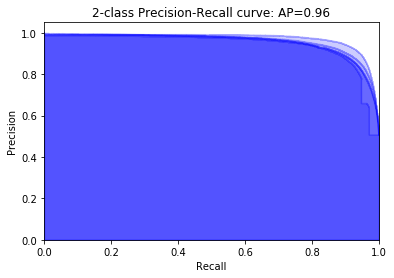

In [44]:
optimizer = BayesianOptimization(f=pipeline,
                                 domain=domain,
                                 acquisition_type='EI',
                                 exact_feval = False
                                )

In [45]:
max_iter = 100     # evaluation budget
eps      = 10e-6  # Minimum allows distance between the las two observations

(1, 12)
d2v_epochs = 18
d2v_vector_size = 436
d2v_window = 6
d2v_min_count = 6
n2v_dimensions = 231
n2v_window = 3
n2v_epochs = 32
n2v_num_walks = 35
n2v_walk_length = 6
n2v_p = 6
n2v_q = 1
nn_dropout = 0.7064035227671414
-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 35
num walks 14698
2 / 35
num walks 29396
3 / 35
num walks 44094
4 / 35
num walks 58792
5 / 35
num walks 73490
6 / 35
num walks 88188
7 / 35
num walks 102886
8 / 35
num walks 117584
9 / 35
num walks 132282
10 / 35
num walks 146980
11 / 35
num walks 161678
12 / 35
num walks 176376
13 / 35
num walks 191074
14 / 35
num walks 205772
15 / 35
num walks 220470
16 / 35
num walks 235168
17 / 35
num walks 249866
18 / 35
num walks 264564
19 / 35
num walks 279262
20 / 35
num walks 293960
21 / 35
num walks 308658
22 / 35
num walks 323356
23 / 35
num walks 338054
24 / 35
num walks 352752
25 / 35
num walks 367450
26 / 35
num walks 382148
27 / 35
num walks 396846
28 / 35
num walks 41

num walks 176376
13 / 23
num walks 191074
14 / 23
num walks 205772
15 / 23
num walks 220470
16 / 23
num walks 235168
17 / 23
num walks 249866
18 / 23
num walks 264564
19 / 23
num walks 279262
20 / 23
num walks 293960
21 / 23
num walks 308658
22 / 23
num walks 323356
23 / 23
num walks 338054
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.6397056579589844)
('Q86W56|PARG_HUMAN', 0.5829963684082031)
('Q6UWZ7|F175A_HUMAN', 0.5394684076309204)
('Q9BX63|FANCJ_HUMAN', 0.5344934463500977)
('Q99728|BARD1_HUMAN', 0.5141074657440186)
('Q659A1|ICE2_HUMAN', 0.4999235272407532)
('P05164|PERM_HUMAN', 0.4796924591064453)
('Q685J3|MUC17_HUMAN', 0.46549198031425476)
('Q9NVH0|EXD2_HUMAN', 0.4439489245414734)
('Q86X24|HORM1_HUMAN', 0.436762273311615)
--------------------------------Training doc2vec--------------------------------
--------------------------Doc2Vec similarity to BRCA1---------------------------
('Q8IUH3|RBM45_HUMAN', 0.77573871612548

--------------------------Doc2Vec similarity to BRCA1---------------------------
('Q9BR77|CCD77_HUMAN', 0.7409330606460571)
('Q9HCI6|K1586_HUMAN', 0.734237015247345)
('Q9HBT8|Z286A_HUMAN', 0.7203704118728638)
('Q86WC4|OSTM1_HUMAN', 0.7183350920677185)
('Q8NA77|TEX19_HUMAN', 0.7162388563156128)
('Q9P2G4|MAP10_HUMAN', 0.7145628333091736)
('A0A0A0MT89|KJ01_HUMAN', 0.7110692262649536)
('Q8IUH3|RBM45_HUMAN', 0.7065445184707642)
('Q6PJP8|DCR1A_HUMAN', 0.7032873630523682)
('Q8IYA2|C144C_HUMAN', 0.7014220952987671)
------------------Generating Training and validation datasets-------------------
Training data shape
x (510846, 1338)
y (510846, 1)
(84988, 1338)
(84988, 1)
----------------------------Training Neural Network-----------------------------
Epoch 1/10
510846/510846 [==============================] - 102s 200us/step - loss: 0.6407 - binary_accuracy: 0.6662s - loss: 0.6408 - binary_accura
Epoch 2/10
510846/510846 [==============================] - 102s 199us/step - loss: 0.5807 - binary_

510846/510846 [==============================] - 102s 199us/step - loss: 0.6941 - binary_accuracy: 0.5061
Epoch 2/10
510846/510846 [==============================] - 101s 197us/step - loss: 0.6941 - binary_accuracy: 0.5059
Epoch 3/10
510846/510846 [==============================] - 101s 197us/step - loss: 0.6941 - binary_accuracy: 0.5060
Epoch 4/10
510846/510846 [==============================] - 100s 197us/step - loss: 0.6943 - binary_accuracy: 0.5060
Epoch 5/10
510846/510846 [==============================] - 101s 197us/step - loss: 0.6943 - binary_accuracy: 0.5055
Epoch 6/10
510846/510846 [==============================] - 100s 197us/step - loss: 0.6940 - binary_accuracy: 0.5059
Epoch 7/10
510846/510846 [==============================] - 101s 197us/step - loss: 0.6940 - binary_accuracy: 0.5059
Epoch 8/10
510846/510846 [==============================] - 100s 197us/step - loss: 0.6939 - binary_accuracy: 0.5062
Epoch 9/10
510846/510846 [==============================] - 101s 197us/step

510846/510846 [==============================] - 96s 187us/step - loss: 0.2073 - binary_accuracy: 0.9349
Epoch 7/10
510846/510846 [==============================] - 96s 187us/step - loss: 0.2015 - binary_accuracy: 0.9380
Epoch 8/10
510846/510846 [==============================] - 96s 187us/step - loss: 0.1964 - binary_accuracy: 0.9417
Epoch 9/10
510846/510846 [==============================] - 96s 187us/step - loss: 0.1929 - binary_accuracy: 0.9449
Epoch 10/10
84988/84988 [==============================] - 2s 26us/step
Training accuracy: 
[0.08793330438858868, 0.9680608245859295]
Validation accuracy: {}
[0.35165371130863493, 0.9028921729761914]
Average precision-recall score: 0.95905
(1, 12)
d2v_epochs = 43
d2v_vector_size = 455
d2v_window = 5
d2v_min_count = 3
n2v_dimensions = 357
n2v_window = 4
n2v_epochs = 39
n2v_num_walks = 45
n2v_walk_length = 36
n2v_p = 2
n2v_q = 5
nn_dropout = 0.5071264213513844
-------------------------------Training Node2Vec--------------------------------
Wal

510846/510846 [==============================] - 109s 214us/step - loss: 0.1972 - binary_accuracy: 0.9334
Epoch 9/10
510846/510846 [==============================] - 114s 223us/step - loss: 0.1935 - binary_accuracy: 0.9347
Epoch 10/10
84988/84988 [==============================] - 2s 27us/step
Training accuracy: 
[0.07968965407161772, 0.9730603743598627]
Validation accuracy: {}
[0.2914497273089875, 0.9132112768693167]
Average precision-recall score: 0.96792
(1, 12)
d2v_epochs = 34
d2v_vector_size = 456
d2v_window = 4
d2v_min_count = 9
n2v_dimensions = 327
n2v_window = 6
n2v_epochs = 5
n2v_num_walks = 34
n2v_walk_length = 18
n2v_p = 7
n2v_q = 5
nn_dropout = 0.2557661661982268
-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 34
num walks 14698
2 / 34
num walks 29396
3 / 34
num walks 44094
4 / 34
num walks 58792
5 / 34
num walks 73490
6 / 34
num walks 88188
7 / 34
num walks 102886
8 / 34
num walks 117584
9 / 34
num walks 132282
10 / 34


84988/84988 [==============================] - 2s 21us/step
Training accuracy: 
[0.2885041911623615, 0.8721043132304901]
Validation accuracy: {}
[0.36192016393800464, 0.8375300042499187]
Average precision-recall score: 0.93139
(1, 12)
d2v_epochs = 7
d2v_vector_size = 453
d2v_window = 3
d2v_min_count = 3
n2v_dimensions = 193
n2v_window = 9
n2v_epochs = 13
n2v_num_walks = 17
n2v_walk_length = 42
n2v_p = 3
n2v_q = 3
nn_dropout = 0.8668676496344405
-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 17
num walks 14698
2 / 17
num walks 29396
3 / 17
num walks 44094
4 / 17
num walks 58792
5 / 17
num walks 73490
6 / 17
num walks 88188
7 / 17
num walks 102886
8 / 17
num walks 117584
9 / 17
num walks 132282
10 / 17
num walks 146980
11 / 17
num walks 161678
12 / 17
num walks 176376
13 / 17
num walks 191074
14 / 17
num walks 205772
15 / 17
num walks 220470
16 / 17
num walks 235168
17 / 17
num walks 249866
--------------------------Node2Vec similari

num walks 161678
12 / 49
num walks 176376
13 / 49
num walks 191074
14 / 49
num walks 205772
15 / 49
num walks 220470
16 / 49
num walks 235168
17 / 49
num walks 249866
18 / 49
num walks 264564
19 / 49
num walks 279262
20 / 49
num walks 293960
21 / 49
num walks 308658
22 / 49
num walks 323356
23 / 49
num walks 338054
24 / 49
num walks 352752
25 / 49
num walks 367450
26 / 49
num walks 382148
27 / 49
num walks 396846
28 / 49
num walks 411544
29 / 49
num walks 426242
30 / 49
num walks 440940
31 / 49
num walks 455638
32 / 49
num walks 470336
33 / 49
num walks 485034
34 / 49
num walks 499732
35 / 49
num walks 514430
36 / 49
num walks 529128
37 / 49
num walks 543826
38 / 49
num walks 558524
39 / 49
num walks 573222
40 / 49
num walks 587920
41 / 49
num walks 602618
42 / 49
num walks 617316
43 / 49
num walks 632014
44 / 49
num walks 646712
45 / 49
num walks 661410
46 / 49
num walks 676108
47 / 49
num walks 690806
48 / 49
num walks 705504
49 / 49
num walks 720202
--------------------------Node2Ve

num walks 29396
3 / 20
num walks 44094
4 / 20
num walks 58792
5 / 20
num walks 73490
6 / 20
num walks 88188
7 / 20
num walks 102886
8 / 20
num walks 117584
9 / 20
num walks 132282
10 / 20
num walks 146980
11 / 20
num walks 161678
12 / 20
num walks 176376
13 / 20
num walks 191074
14 / 20
num walks 205772
15 / 20
num walks 220470
16 / 20
num walks 235168
17 / 20
num walks 249866
18 / 20
num walks 264564
19 / 20
num walks 279262
20 / 20
num walks 293960
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.6692137718200684)
('Q86W56|PARG_HUMAN', 0.6439559459686279)
('Q86X24|HORM1_HUMAN', 0.5726088285446167)
('Q6UWZ7|F175A_HUMAN', 0.565517783164978)
('Q99728|BARD1_HUMAN', 0.538086473941803)
('Q9BX63|FANCJ_HUMAN', 0.5315759181976318)
('Q9NVH0|EXD2_HUMAN', 0.5271340608596802)
('Q659A1|ICE2_HUMAN', 0.5225930213928223)
('Q685J3|MUC17_HUMAN', 0.48434656858444214)
('Q8IYX8|CE57L_HUMAN', 0.4841163754463196)
--------------------------------Traini

num walks 102886
8 / 24
num walks 117584
9 / 24
num walks 132282
10 / 24
num walks 146980
11 / 24
num walks 161678
12 / 24
num walks 176376
13 / 24
num walks 191074
14 / 24
num walks 205772
15 / 24
num walks 220470
16 / 24
num walks 235168
17 / 24
num walks 249866
18 / 24
num walks 264564
19 / 24
num walks 279262
20 / 24
num walks 293960
21 / 24
num walks 308658
22 / 24
num walks 323356
23 / 24
num walks 338054
24 / 24
num walks 352752
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.6081162691116333)
('Q86W56|PARG_HUMAN', 0.5954242944717407)
('Q6UWZ7|F175A_HUMAN', 0.5623849630355835)
('Q86X24|HORM1_HUMAN', 0.5619099736213684)
('Q659A1|ICE2_HUMAN', 0.5422306060791016)
('Q9BX63|FANCJ_HUMAN', 0.5315896272659302)
('Q99728|BARD1_HUMAN', 0.5298628807067871)
('Q685J3|MUC17_HUMAN', 0.5134143829345703)
('Q9NVH0|EXD2_HUMAN', 0.5098828077316284)
('P05164|PERM_HUMAN', 0.4976966977119446)
--------------------------------Training doc2vec-----

num walks 426242
30 / 38
num walks 440940
31 / 38
num walks 455638
32 / 38
num walks 470336
33 / 38
num walks 485034
34 / 38
num walks 499732
35 / 38
num walks 514430
36 / 38
num walks 529128
37 / 38
num walks 543826
38 / 38
num walks 558524
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.5425883531570435)
('Q6UWZ7|F175A_HUMAN', 0.4815686345100403)
('Q86W56|PARG_HUMAN', 0.45756033062934875)
('Q99728|BARD1_HUMAN', 0.4431123733520508)
('Q685J3|MUC17_HUMAN', 0.40939003229141235)
('Q659A1|ICE2_HUMAN', 0.4048394560813904)
('Q9BX63|FANCJ_HUMAN', 0.3993425965309143)
('Q86X24|HORM1_HUMAN', 0.39721232652664185)
('Q8NFP4|MDGA1_HUMAN', 0.36958107352256775)
('P05164|PERM_HUMAN', 0.3545771539211273)
--------------------------------Training doc2vec--------------------------------
--------------------------Doc2Vec similarity to BRCA1---------------------------
('Q5JX71|F209A_HUMAN', 0.5216359496116638)
('Q5JR59|MTUS2_HUMAN', 0.5141081809997559

num walks 676108
47 / 49
num walks 690806
48 / 49
num walks 705504
49 / 49
num walks 720202
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.5865579843521118)
('Q6UWZ7|F175A_HUMAN', 0.49608859419822693)
('Q86W56|PARG_HUMAN', 0.4891408085823059)
('Q9BX63|FANCJ_HUMAN', 0.4513709247112274)
('Q86X24|HORM1_HUMAN', 0.44481343030929565)
('Q99728|BARD1_HUMAN', 0.4361628293991089)
('Q9NVH0|EXD2_HUMAN', 0.4042988419532776)
('Q685J3|MUC17_HUMAN', 0.40045636892318726)
('P05164|PERM_HUMAN', 0.39779144525527954)
('Q659A1|ICE2_HUMAN', 0.39385050535202026)
--------------------------------Training doc2vec--------------------------------
--------------------------Doc2Vec similarity to BRCA1---------------------------
('Q9HCI6|K1586_HUMAN', 0.6766083240509033)
('A0A0A0MT89|KJ01_HUMAN', 0.6537339687347412)
('Q9BR77|CCD77_HUMAN', 0.653357744216919)
('Q86WC4|OSTM1_HUMAN', 0.6398024559020996)
('O96006|ZBED1_HUMAN', 0.6384368538856506)
('Q8IUH3|RBM45_HU

--------------------------Doc2Vec similarity to BRCA1---------------------------
('Q5MJ10|SPXN2_HUMAN', 0.4021771252155304)
('Q9C0C2|TB182_HUMAN', 0.3989030718803406)
('E5RHQ5|NPB11_HUMAN', 0.39563876390457153)
('Q5MJ09|SPXN3_HUMAN', 0.3954926133155823)
('Q96LP6|CL042_HUMAN', 0.39493831992149353)
('Q8NA77|TEX19_HUMAN', 0.39469337463378906)
('Q5JR59|MTUS2_HUMAN', 0.3902823328971863)
('P0CG35|TB15B_HUMAN', 0.3893353044986725)
('Q9HCI6|K1586_HUMAN', 0.3889828026294708)
('Q5MJ08|SPXN4_HUMAN', 0.3815693259239197)
------------------Generating Training and validation datasets-------------------
Training data shape
x (510846, 966)
y (510846, 1)
(84988, 966)
(84988, 1)
----------------------------Training Neural Network-----------------------------
Epoch 1/10
510846/510846 [==============================] - 106s 207us/step - loss: 0.8432 - binary_accuracy: 0.5553
Epoch 2/10
510846/510846 [==============================] - 104s 204us/step - loss: 0.7831 - binary_accuracy: 0.6127
Epoch 3/10
51084

Training data shape
x (510846, 1282)
y (510846, 1)
(84988, 1282)
(84988, 1)
----------------------------Training Neural Network-----------------------------
Epoch 1/10
510846/510846 [==============================] - 123s 240us/step - loss: 0.5282 - binary_accuracy: 0.7509
Epoch 2/10
510846/510846 [==============================] - 119s 234us/step - loss: 0.4398 - binary_accuracy: 0.8195
Epoch 3/10
510846/510846 [==============================] - 121s 237us/step - loss: 0.4174 - binary_accuracy: 0.8341
Epoch 4/10
510846/510846 [==============================] - 122s 240us/step - loss: 0.4060 - binary_accuracy: 0.8431
Epoch 5/10
510846/510846 [==============================] - 124s 243us/step - loss: 0.4005 - binary_accuracy: 0.8484
Epoch 6/10
510846/510846 [==============================] - 146s 286us/step - loss: 0.3972 - binary_accuracy: 0.8520s - loss: 0.3973 - binary_accura
Epoch 7/10
510846/510846 [==============================] - 136s 266us/step - loss: 0.3967 - binary_accuracy:

Epoch 1/10
510846/510846 [==============================] - 129s 253us/step - loss: 0.3424 - binary_accuracy: 0.8545
Epoch 2/10
510846/510846 [==============================] - 128s 250us/step - loss: 0.2200 - binary_accuracy: 0.9148
Epoch 3/10
510846/510846 [==============================] - 127s 249us/step - loss: 0.1797 - binary_accuracy: 0.9338
Epoch 4/10
510846/510846 [==============================] - 127s 249us/step - loss: 0.1585 - binary_accuracy: 0.9438
Epoch 5/10
510846/510846 [==============================] - 127s 248us/step - loss: 0.1428 - binary_accuracy: 0.9505
Epoch 6/10
510846/510846 [==============================] - 127s 249us/step - loss: 0.1325 - binary_accuracy: 0.9548
Epoch 7/10
510846/510846 [==============================] - 127s 249us/step - loss: 0.1248 - binary_accuracy: 0.9591
Epoch 8/10
510846/510846 [==============================] - 127s 249us/step - loss: 0.1146 - binary_accuracy: 0.9620
Epoch 9/10
510846/510846 [==============================] - 128s

510846/510846 [==============================] - 115s 224us/step - loss: 0.3165 - binary_accuracy: 0.8800
Epoch 4/10
510846/510846 [==============================] - 120s 235us/step - loss: 0.2951 - binary_accuracy: 0.8922 - ETA: 2s - loss:
Epoch 5/10
510846/510846 [==============================] - 115s 224us/step - loss: 0.2818 - binary_accuracy: 0.8996
Epoch 6/10
510846/510846 [==============================] - 120s 235us/step - loss: 0.2712 - binary_accuracy: 0.9053s - loss: 0.2713 - binary_acc
Epoch 7/10
510846/510846 [==============================] - 115s 225us/step - loss: 0.2620 - binary_accuracy: 0.9095
Epoch 8/10
510846/510846 [==============================] - 120s 235us/step - loss: 0.2587 - binary_accuracy: 0.9119
Epoch 9/10
510846/510846 [==============================] - 115s 225us/step - loss: 0.2511 - binary_accuracy: 0.9158
Epoch 10/10
84988/84988 [==============================] - 3s 39us/step
Training accuracy: 
[0.108553404992934, 0.9576212792120475]
Validation ac

510846/510846 [==============================] - 97s 190us/step - loss: 0.3668 - binary_accuracy: 0.8363
Epoch 2/10
510846/510846 [==============================] - 95s 186us/step - loss: 0.2194 - binary_accuracy: 0.9153
Epoch 3/10
510846/510846 [==============================] - 95s 186us/step - loss: 0.1808 - binary_accuracy: 0.9338
Epoch 4/10
510846/510846 [==============================] - 95s 186us/step - loss: 0.1630 - binary_accuracy: 0.9421
Epoch 5/10
510846/510846 [==============================] - 95s 186us/step - loss: 0.1512 - binary_accuracy: 0.9473
Epoch 6/10
510846/510846 [==============================] - 95s 186us/step - loss: 0.1453 - binary_accuracy: 0.9516
Epoch 7/10
510846/510846 [==============================] - 95s 185us/step - loss: 0.1468 - binary_accuracy: 0.9552
Epoch 8/10
510846/510846 [==============================] - 95s 186us/step - loss: 0.1478 - binary_accuracy: 0.95714s - ETA: 1s - loss: 0.1479
Epoch 9/10
510846/510846 [==============================

510846/510846 [==============================] - 110s 215us/step - loss: 0.3363 - binary_accuracy: 0.8639
Epoch 3/10
510846/510846 [==============================] - 110s 215us/step - loss: 0.2971 - binary_accuracy: 0.8863
Epoch 4/10
510846/510846 [==============================] - 110s 215us/step - loss: 0.2725 - binary_accuracy: 0.9002
Epoch 5/10
510846/510846 [==============================] - 110s 215us/step - loss: 0.2562 - binary_accuracy: 0.9090
Epoch 6/10
510846/510846 [==============================] - 110s 215us/step - loss: 0.2439 - binary_accuracy: 0.9148
Epoch 7/10
510846/510846 [==============================] - 110s 216us/step - loss: 0.2353 - binary_accuracy: 0.9207s - loss: 0.235
Epoch 8/10
510846/510846 [==============================] - 110s 216us/step - loss: 0.2276 - binary_accuracy: 0.9250
Epoch 9/10
510846/510846 [==============================] - 110s 216us/step - loss: 0.2230 - binary_accuracy: 0.9272
Epoch 10/10
84988/84988 [==============================] - 3

510846/510846 [==============================] - 91s 178us/step - loss: 0.3555 - binary_accuracy: 0.8756
Epoch 10/10
84988/84988 [==============================] - 2s 26us/step
Training accuracy: 
[0.18501644979105553, 0.9320303966375684]
Validation accuracy: {}
[0.29354049158151296, 0.8941732950842778]
Average precision-recall score: 0.95645
(1, 12)
d2v_epochs = 6
d2v_vector_size = 357
d2v_window = 6
d2v_min_count = 3
n2v_dimensions = 436
n2v_window = 8
n2v_epochs = 8
n2v_num_walks = 39
n2v_walk_length = 26
n2v_p = 1
n2v_q = 2
nn_dropout = 0.7908683377481092
-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 39
num walks 14698
2 / 39
num walks 29396
3 / 39
num walks 44094
4 / 39
num walks 58792
5 / 39
num walks 73490
6 / 39
num walks 88188
7 / 39
num walks 102886
8 / 39
num walks 117584
9 / 39
num walks 132282
10 / 39
num walks 146980
11 / 39
num walks 161678
12 / 39
num walks 176376
13 / 39
num walks 191074
14 / 39
num walks 205772
1

Average precision-recall score: 0.95677
(1, 12)
d2v_epochs = 33
d2v_vector_size = 379
d2v_window = 8
d2v_min_count = 2
n2v_dimensions = 112
n2v_window = 6
n2v_epochs = 21
n2v_num_walks = 14
n2v_walk_length = 29
n2v_p = 4
n2v_q = 4
nn_dropout = 0.24383179780778874
-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 14
num walks 14698
2 / 14
num walks 29396
3 / 14
num walks 44094
4 / 14
num walks 58792
5 / 14
num walks 73490
6 / 14
num walks 88188
7 / 14
num walks 102886
8 / 14
num walks 117584
9 / 14
num walks 132282
10 / 14
num walks 146980
11 / 14
num walks 161678
12 / 14
num walks 176376
13 / 14
num walks 191074
14 / 14
num walks 205772
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q99728|BARD1_HUMAN', 0.7185132503509521)
('Q9BX63|FANCJ_HUMAN', 0.691224217414856)
('Q659A1|ICE2_HUMAN', 0.6830483675003052)
('Q93097|WNT2B_HUMAN', 0.6818746328353882)
('Q6UWZ7|F175A_HUMAN', 0.6677722930908203)
('Q86W56|

num walks 382148
27 / 43
num walks 396846
28 / 43
num walks 411544
29 / 43
num walks 426242
30 / 43
num walks 440940
31 / 43
num walks 455638
32 / 43
num walks 470336
33 / 43
num walks 485034
34 / 43
num walks 499732
35 / 43
num walks 514430
36 / 43
num walks 529128
37 / 43
num walks 543826
38 / 43
num walks 558524
39 / 43
num walks 573222
40 / 43
num walks 587920
41 / 43
num walks 602618
42 / 43
num walks 617316
43 / 43
num walks 632014
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q93097|WNT2B_HUMAN', 0.5480549335479736)
('Q6UWZ7|F175A_HUMAN', 0.4602340757846832)
('Q685J3|MUC17_HUMAN', 0.4268101453781128)
('Q9BX63|FANCJ_HUMAN', 0.42679762840270996)
('Q86X24|HORM1_HUMAN', 0.42631587386131287)
('Q99728|BARD1_HUMAN', 0.4253697991371155)
('Q86W56|PARG_HUMAN', 0.4213353991508484)
('Q659A1|ICE2_HUMAN', 0.4186031222343445)
('Q9NVH0|EXD2_HUMAN', 0.41591188311576843)
('Q8IYX8|CE57L_HUMAN', 0.3517921566963196)
--------------------------------Training doc2ve

--------------------------Doc2Vec similarity to BRCA1---------------------------
('P59773|MNARL_HUMAN', 0.9318051934242249)
('A0A0A0MT89|KJ01_HUMAN', 0.9304873943328857)
('Q13796|SHRM2_HUMAN', 0.9223511219024658)
('O96006|ZBED1_HUMAN', 0.9172410368919373)
('Q16665|HIF1A_HUMAN', 0.9158221483230591)
('Q6AZY7|SCAR3_HUMAN', 0.9149144291877747)
('Q9Y2H8|ZN510_HUMAN', 0.9124681949615479)
('Q8IUH3|RBM45_HUMAN', 0.9062345623970032)
('P51587|BRCA2_HUMAN', 0.9058635830879211)
('Q6PJP8|DCR1A_HUMAN', 0.8920512199401855)
------------------Generating Training and validation datasets-------------------
Training data shape
x (510846, 1114)
y (510846, 1)
(84988, 1114)
(84988, 1)
----------------------------Training Neural Network-----------------------------
Epoch 1/10
510846/510846 [==============================] - 131s 257us/step - loss: 0.5705 - binary_accuracy: 0.7353
Epoch 2/10
510846/510846 [==============================] - 129s 253us/step - loss: 0.5138 - binary_accuracy: 0.7948
Epoch 3/10
510

Training data shape
x (510846, 888)
y (510846, 1)
(84988, 888)
(84988, 1)
----------------------------Training Neural Network-----------------------------
Epoch 1/10
510846/510846 [==============================] - 112s 219us/step - loss: 0.4139 - binary_accuracy: 0.8189
Epoch 2/10
510846/510846 [==============================] - 107s 209us/step - loss: 0.2985 - binary_accuracy: 0.8829
Epoch 3/10
510846/510846 [==============================] - 109s 213us/step - loss: 0.2594 - binary_accuracy: 0.9028
Epoch 4/10
510846/510846 [==============================] - 140s 274us/step - loss: 0.2397 - binary_accuracy: 0.9135
Epoch 5/10
510846/510846 [==============================] - 199s 389us/step - loss: 0.2318 - binary_accuracy: 0.9196
Epoch 6/10
510846/510846 [==============================] - 191s 374us/step - loss: 0.2229 - binary_accuracy: 0.9241
Epoch 7/10
510846/510846 [==============================] - 206s 404us/step - loss: 0.2165 - binary_accuracy: 0.9286
Epoch 8/10
510846/510846 [

Epoch 1/10
510846/510846 [==============================] - 141s 276us/step - loss: 0.4646 - binary_accuracy: 0.7864
Epoch 2/10
510846/510846 [==============================] - 132s 259us/step - loss: 0.3590 - binary_accuracy: 0.8524
Epoch 3/10
510846/510846 [==============================] - 132s 258us/step - loss: 0.3243 - binary_accuracy: 0.8739
Epoch 4/10
510846/510846 [==============================] - 132s 259us/step - loss: 0.3077 - binary_accuracy: 0.8867
Epoch 5/10
510846/510846 [==============================] - 132s 258us/step - loss: 0.2938 - binary_accuracy: 0.8962
Epoch 6/10
510846/510846 [==============================] - 133s 260us/step - loss: 0.2820 - binary_accuracy: 0.9028
Epoch 7/10
510846/510846 [==============================] - 133s 260us/step - loss: 0.2687 - binary_accuracy: 0.9097
Epoch 8/10
510846/510846 [==============================] - 133s 260us/step - loss: 0.2584 - binary_accuracy: 0.9147
Epoch 9/10
510846/510846 [==============================] - 132s

Epoch 1/10
510846/510846 [==============================] - 273s 534us/step - loss: 0.5811 - binary_accuracy: 0.7099
Epoch 2/10
510846/510846 [==============================] - 184s 360us/step - loss: 0.4942 - binary_accuracy: 0.7840
Epoch 3/10
510846/510846 [==============================] - 205s 401us/step - loss: 0.4626 - binary_accuracy: 0.8073
Epoch 4/10
510846/510846 [==============================] - 276s 540us/step - loss: 0.4462 - binary_accuracy: 0.8189
Epoch 5/10
510846/510846 [==============================] - 277s 542us/step - loss: 0.4311 - binary_accuracy: 0.8275
Epoch 6/10
510846/510846 [==============================] - 292s 572us/step - loss: 0.4229 - binary_accuracy: 0.8345
Epoch 7/10
510846/510846 [==============================] - 286s 560us/step - loss: 0.4146 - binary_accuracy: 0.8405
Epoch 8/10
510846/510846 [==============================] - 279s 546us/step - loss: 0.4093 - binary_accuracy: 0.8452s - loss:
Epoch 9/10
510846/510846 [=============================

510846/510846 [==============================] - 158s 309us/step - loss: 0.6017 - binary_accuracy: 0.6965s - loss: 0.6019 - bin
Epoch 2/10
 23424/510846 [>.............................] - ETA: 3:50 - loss: 0.5373 - binary_accuracy: 0.7588

KeyboardInterrupt: 

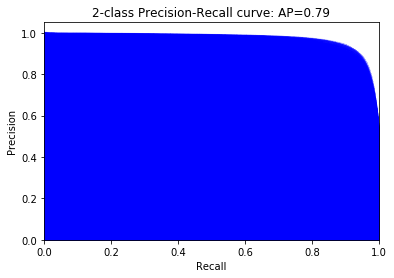

In [46]:
optimizer.run_optimization(max_iter,eps=eps)

#### Best parameters
```
d2v_epochs = 21
d2v_vector_size = 99
d2v_window = 8
d2v_min_count = 9
n2v_dimensions = 104
n2v_window = 6
n2v_epochs = 30
n2v_num_walks = 32
n2v_walk_length = 27
n2v_p = 4
n2v_q = 2
```

In [56]:
optimizer.get_evaluations()

(array([[2.10000000e+01, 9.90000000e+01, 8.00000000e+00, 9.00000000e+00,
         1.04000000e+02, 6.00000000e+00, 3.00000000e+01, 3.20000000e+01,
         2.70000000e+01, 4.00000000e+00, 2.00000000e+00, 2.28181549e-01],
        [4.00000000e+01, 1.76000000e+02, 8.00000000e+00, 3.00000000e+00,
         3.46000000e+02, 7.00000000e+00, 3.60000000e+01, 4.70000000e+01,
         3.90000000e+01, 7.00000000e+00, 4.00000000e+00, 4.15809435e-01],
        [1.90000000e+01, 4.35000000e+02, 8.00000000e+00, 7.00000000e+00,
         2.28000000e+02, 9.00000000e+00, 2.20000000e+01, 3.30000000e+01,
         1.40000000e+01, 1.00000000e+00, 5.00000000e+00, 5.66020943e-01],
        [4.90000000e+01, 1.22000000e+02, 7.00000000e+00, 4.00000000e+00,
         3.15000000e+02, 8.00000000e+00, 2.30000000e+01, 2.30000000e+01,
         8.00000000e+00, 7.00000000e+00, 3.00000000e+00, 1.57435696e-01],
        [9.00000000e+00, 2.26000000e+02, 5.00000000e+00, 1.00000000e+00,
         4.97000000e+02, 7.00000000e+00, 3.3000

In [60]:
optimizer.

error: failed in converting 2nd argument `b' of _flapack.dpotrs to C/Fortran array